Mean ROC-AUC: 0.9613333333333335 (95% CI: 0.954727537038309, 0.9679391296283579)
Mean PR-AUC: 0.4481329838598199 (95% CI: 0.4370976244297931, 0.45916834328984674)
Mean F1 Score: 0.9139322629564403 (95% CI: 0.9062214261050742, 0.9216430998078063)
Mean Matthews Correlation Coefficient: 0.8240028191728154 (95% CI: 0.8077111147264184, 0.8402945236192123)


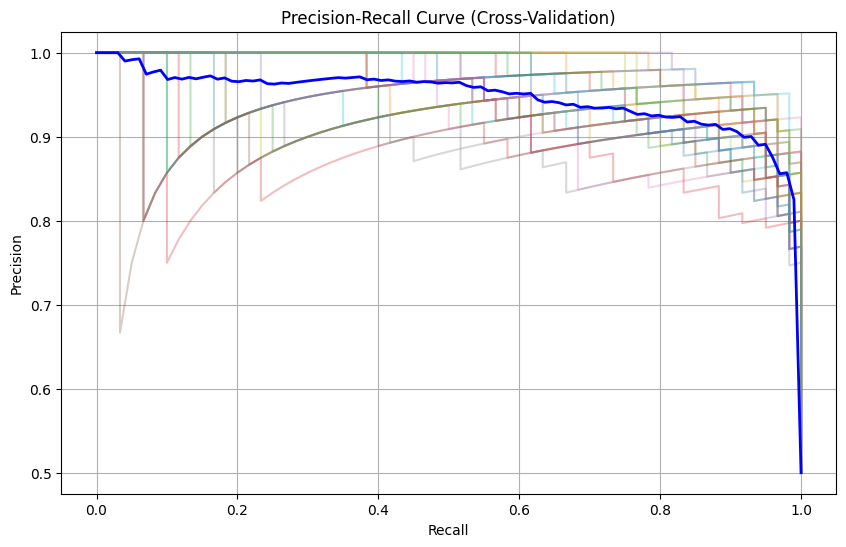

In [4]:

from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

# Run the dataInfo notebook to preprocess the data
%run dataInfo.ipynb

# Load the train and test datasets
train_df = train_df.dropna()  # Drop missing values in training data
test_df = test_df.dropna()  # Drop missing values in test data
# Preprocess the train dataset
X = train_df.drop(columns=['Class/ASD'])
y = train_df['Class/ASD']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Define stratified 10-fold CV with 3 repeats
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# Initialize lists to store metrics
roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

# Perform cross-validation
for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred = catboost_model.predict(X_val)
    y_val_pred_proba = catboost_model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    pr_auc = np.trapezoid(recall, precision)
    f1 = f1_score(y_val, y_val_pred)
    mcc = matthews_corrcoef(y_val, y_val_pred)

    # Append metrics to lists
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    mcc_scores.append(mcc)

# Calculate mean and confidence intervals for each metric
def calculate_ci(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

mean_roc_auc, ci_lower_roc_auc, ci_upper_roc_auc = calculate_ci(roc_auc_scores)
mean_pr_auc, ci_lower_pr_auc, ci_upper_pr_auc = calculate_ci(pr_auc_scores)
mean_f1, ci_lower_f1, ci_upper_f1 = calculate_ci(f1_scores)
mean_mcc, ci_lower_mcc, ci_upper_mcc = calculate_ci(mcc_scores)

# Print results
print(f"Mean ROC-AUC: {mean_roc_auc} (95% CI: {ci_lower_roc_auc}, {ci_upper_roc_auc})")
print(f"Mean PR-AUC: {mean_pr_auc} (95% CI: {ci_lower_pr_auc}, {ci_upper_pr_auc})")
print(f"Mean F1 Score: {mean_f1} (95% CI: {ci_lower_f1}, {ci_upper_f1})")
print(f"Mean Matthews Correlation Coefficient: {mean_mcc} (95% CI: {ci_lower_mcc}, {ci_upper_mcc})")

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))

# Initialize lists to store aggregated precision and recall
all_precision = []
all_recall = []

for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred_proba = catboost_model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)

    # Store precision and recall for aggregation
    all_precision.append(precision)
    all_recall.append(recall)

    # Plot the curve for this fold
    plt.plot(recall, precision, alpha=0.3, label='Fold PR Curve')

# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

KeyboardInterrupt: 

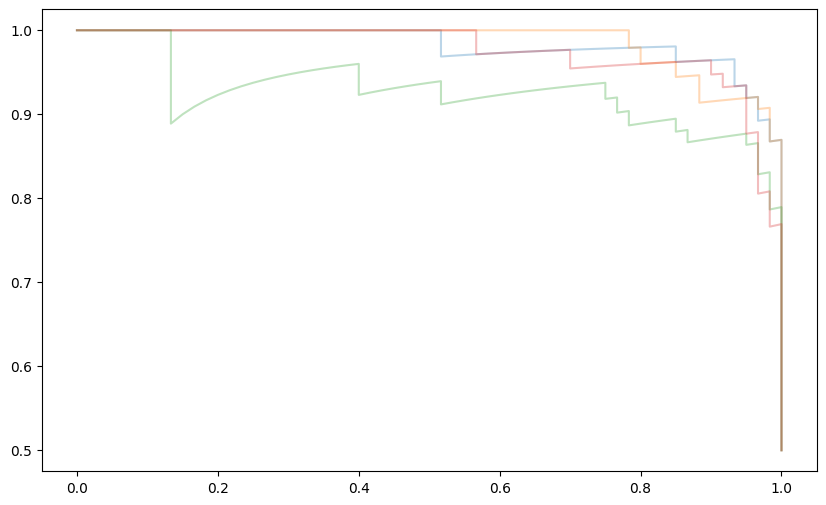

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))

# Initialize lists to store aggregated precision and recall
all_precision = []
all_recall = []

for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    catboost_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred_proba = catboost_model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)

    # Store precision and recall for aggregation
    all_precision.append(precision)
    all_recall.append(recall)

    # Plot the curve for this fold
    plt.plot(recall, precision, alpha=0.3, label='Fold PR Curve')

# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()